# GradientBoosting model for Ames

# Contents

[GradientBoosting](#GradientBoosting)

[Model Tuning](#Model-Tuning)

[Feature Importances](#Feature-Importances)

[Summary](#Summary)

[Resources](#Resources)

In [1]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, OrdinalEncoder
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn import ensemble

## Import raw data for reference

In [3]:
ames_raw = pd.read_csv('Ames_Housing_Price_Data.csv', index_col=0).reset_index()
ames_raw.drop(columns=['index'], inplace=True)
ames_raw.head(2)

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,909176150,856,126000,30,RL,NaN,7890,Pave,NaN,Reg,...,166,0,NaN,NaN,NaN,0,3,2010,WD,Normal
1,905476230,1049,139500,120,RL,42.0,4235,Pave,NaN,Reg,...,0,0,NaN,NaN,NaN,0,2,2009,WD,Normal


In [5]:
ames = pd.read_pickle('ames_clean.pkl')
ames.head(2)

,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,856,126000,30,RL,68.0,7890,Pave,None,Reg,Lvl,...,166,0,None,None,None,0,3,2010,WD,Normal
1,1049,139500,120,RL,42.0,4235,Pave,None,Reg,Lvl,...,0,0,None,None,None,0,2,2009,WD,Normal


In [7]:
# remove target from dataframe
y = ames['SalePrice']
ames.drop(columns=['SalePrice'], axis=1, inplace=True)
ames.head(2)

,GrLivArea,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,856,30,RL,68.0,7890,Pave,None,Reg,Lvl,AllPub,...,166,0,None,None,None,0,3,2010,WD,Normal
1,1049,120,RL,42.0,4235,Pave,None,Reg,Lvl,AllPub,...,0,0,None,None,None,0,2,2009,WD,Normal


## Import cleaned data for modeling

**Summary of previous data cleaning:**

From **Ames_Data_Cleaning.ipynb**, the following modifications were made to the Ames dataset:

**Data Types**
- OverallQual and OverallCond reclassified as ordinal datatypes (per data dictionary)
- MSSubClass reclassified as categorical (nominal) datatype
- MoSold and YrSold redefined as categorical datatypes for modeling options
- Other date features remain numeric types, to prevent dimensionality problems when ordinal encoding
- GarageYrBlt changed from 'float' to 'int', after imputation of missing values, to match other date features.


**Missing Data and Imputation**
- Numerical Features:
    - After exploring relationship between GarageYrBlt and YearBuilt, imputed missing values with YearBuilt
    - After evaluating relationship between LotArea and LotFrontage, imputed LotFrontage with median
    - Imputed remaining numerical features with median values (meadian values are the same as the mode values for discrete features)
- Categorical Features:
    - Imputed missing Electrical value with mode value
    - After evaluating Garage features, imputed missing values with 'None'
    - Imputed remaining categorical features with 'None'

**ames_clean.pkl** include these changes.

In [10]:
# Define numerical features without target SalePrice
numerical_features_list = ames.select_dtypes(include=['float64', 'int64']).columns.to_list()
print(f'number of numerical features (without target): {len(numerical_features_list)}')
numerical_features = ames[numerical_features_list]
numerical_features.head(2)

number of numerical features (without target): 31


,GrLivArea,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,856,68.0,7890,1939,1950,0.0,238.0,0.0,618.0,856.0,...,1939,2.0,399.0,0,0,0,0,166,0,0
1,1049,42.0,4235,1984,1984,149.0,552.0,393.0,104.0,1049.0,...,1984,1.0,266.0,0,105,0,0,0,0,0


In [12]:
# Define nominal features from Ames_Data_Cleaning.ipynb analysis
nominal_features_list = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LandContour',
                        'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 
                        'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 
                        'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'GarageType',
                        'MiscFeature', 'SaleType', 'SaleCondition']

print(f'number of nominal features: {len(nominal_features_list)}')
nominal_features = ames[nominal_features_list]
nominal_features.head(2)

number of nominal features: 23


,MSSubClass,MSZoning,Street,Alley,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,...,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,CentralAir,GarageType,MiscFeature,SaleType,SaleCondition
0,30,RL,Pave,None,Lvl,Corner,SWISU,Norm,Norm,1Fam,...,Wd Sdng,Wd Sdng,None,CBlock,GasA,Y,Detchd,None,WD,Normal
1,120,RL,Pave,None,Lvl,Inside,Edwards,Norm,Norm,TwnhsE,...,HdBoard,HdBoard,BrkFace,CBlock,GasA,Y,Attchd,None,WD,Normal


In [14]:
# Define ordinal features from Ames_Data_Cleaning.ipynb analysis
# extract ordinal_features_list from ordinal_order below
ordinal_features_list = ['Electrical', 'LotShape', 'Utilities', 'LandSlope', 'OverallQual', 'OverallCond',
                        'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                        'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'Functional',
                        'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
                        'PoolQC', 'Fence', 'MoSold', 'YrSold']
print(f'number of ordinal features: {len(ordinal_features_list)}')
ordinal_features = ames[ordinal_features_list]
ordinal_features.head(2)

number of ordinal features: 25


,Electrical,LotShape,Utilities,LandSlope,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,...,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MoSold,YrSold
0,SBrkr,Reg,AllPub,Gtl,6,6,TA,TA,TA,TA,...,Typ,Gd,Unf,TA,TA,Y,None,None,3,2010
1,SBrkr,Reg,AllPub,Gtl,5,5,Gd,TA,Gd,TA,...,Typ,None,Fin,TA,TA,Y,None,None,2,2009


In [16]:
# # Define categorical features
# categorical_features_list = ames.select_dtypes(include=['object']).columns.to_list()
# print(f'number of categorical features: {len(categorical_features_list)}')
# categorical_features = ames[categorical_features_list]
# categorical_features.head(2)

OverallQual and OverallCond, while reclassified as object types, are still int types. Convert OverallQual, OverallCond, YrSold, and MoSold from int type to str type for ordinal encoding.

In [19]:
str_OverallQual = ames['OverallQual'].astype(str)
str_OverallCond = ames['OverallCond'].astype(str)
print(type(ames['OverallQual'][0]))
print(type(str_OverallQual[0]))

<class 'int'>
<class 'str'>


In [21]:
ames['OverallCond'] = ames['OverallCond'].astype(str)
ames['OverallQual'] = ames['OverallQual'].astype(str)
ames['MoSold'] = ames['MoSold'].astype(str)
ames['YrSold'] = ames['YrSold'].astype(str)

In [23]:
# define ordering for ordinal features
ordinal_order = {
    'Electrical': ['Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],  # Electrical system
    'LotShape': ['IR3', 'IR2', 'IR1', 'Reg'],  # General shape of property
    'Utilities': ['ELO', 'NoSeWa', 'NoSewr', 'AllPub'],  # Type of utilities available
    'LandSlope': ['Sev', 'Mod', 'Gtl'],  # Slope of property
    # Overalls here in other notebook
    'OverallQual': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'],
    'OverallCond': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'],
    #
    'ExterQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Evaluates the quality of the material on the exterior
    'ExterCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Evaluates the present condition of the material on the exterior
    'BsmtQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Height of the basement
    'BsmtCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # General condition of the basement
    'BsmtExposure': ['None', 'No', 'Mn', 'Av', 'Gd'],  # Walkout or garden level basement walls
    'BsmtFinType1': ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],  # Quality of basement finished area
    'BsmtFinType2': ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],  # Quality of second basement finished area
    'HeatingQC': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Heating quality and condition
    'KitchenQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Kitchen quality
    'Functional': ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],  # Home functionality
    'FireplaceQu': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Fireplace quality
    'GarageFinish': ['None', 'Unf', 'RFn', 'Fin'],  # Interior finish of the garage
    'GarageQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Garage quality
    'GarageCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Garage condition
    'PavedDrive': ['N', 'P', 'Y'],  # Paved driveway
    'PoolQC': ['None', 'Fa', 'TA', 'Gd', 'Ex'],  # Pool quality
    'Fence': ['None', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'],  # Fence quality
    'MoSold': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'],
    'YrSold': ['2006', '2007', '2008', '2009', '2010']
    # 'MoSold': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],  
    # 'YrSold': [2006, 2007, 2008, 2009, 2010]
}

In [25]:
# get list of ordinal features that syncs with ordinal dictionary 
ordinal_features_list = list(ordinal_order.keys())
print(f'number of ordinal features: {len(ordinal_features_list)}')
ordinal_features = ames[ordinal_features_list]
ordinal_features.head(2)

number of ordinal features: 25


,Electrical,LotShape,Utilities,LandSlope,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,...,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MoSold,YrSold
0,SBrkr,Reg,AllPub,Gtl,6,6,TA,TA,TA,TA,...,Typ,Gd,Unf,TA,TA,Y,None,None,3,2010
1,SBrkr,Reg,AllPub,Gtl,5,5,Gd,TA,Gd,TA,...,Typ,None,Fin,TA,TA,Y,None,None,2,2009


In [27]:
# stack features for processing: numerical + nominal + ordinal
X = ames[numerical_features_list].join(ames[nominal_features_list])
X = X.join(ames[ordinal_features_list])
X.head(2)

,GrLivArea,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MoSold,YrSold
0,856,68.0,7890,1939,1950,0.0,238.0,0.0,618.0,856.0,...,Typ,Gd,Unf,TA,TA,Y,None,None,3,2010
1,1049,42.0,4235,1984,1984,149.0,552.0,393.0,104.0,1049.0,...,Typ,None,Fin,TA,TA,Y,None,None,2,2009


# GradientBoosting

[Contents](#Contents)

**Method:**

1. Build pipeline:
- numerical features - no scaling; passthrough
- nominal features: one-hot encode
- ordinal features: ordinal encode

2. Get a base model: evaluate model on full dataset and default parameters using cross validation
   
3. Tune hyperparameters with GridSearchCV 
- fit grid object to full dataset and retrieve cv score for full dataset (X and y). This is the score that will be used to evaluate the model and compare to other models. 
- fit grid object to train and test data to examine train-test gap for overfitting.

4. Choose best optimized model (based on highest cv score)

# 1. Build Pipeline

In [34]:
# define transformer for numerical features
numerical_transformer = Pipeline(steps=[
    ('num', 'passthrough')
])

# define one-hot transformer for nominal features
nominal_transformer = Pipeline(steps=[
    ('nominal', OneHotEncoder(handle_unknown='ignore'))
])

# define categories for ordinal encoding
ord_categories = [ordinal_order[feature] for feature in ordinal_features_list]

# define ordinal transformer
ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(categories=ord_categories))
])

# Set up preprocessor for all features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features_list),
        ('nominal', nominal_transformer, nominal_features_list),
        ('ordinal', ordinal_transformer, ordinal_features_list)
])

# define model pipeline with preprocessor and regressor on default params
pipeline = Pipeline(
    steps=[('preprocessor', preprocessor), 
           ('regressor', ensemble.GradientBoostingRegressor(random_state=42))
          ]
)

In [36]:
pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num',
                                                                   'passthrough')]),
                                                  ['GrLivArea', 'LotFrontage',
                                                   'LotArea', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF', 'TotalBsmtSF',
                                                   '1stFlrSF', '2ndFlrSF',
                                                   'LowQualFinSF',
                                                   'BsmtFullBath',
                                                   'BsmtHalfBath', 'FullBath',
                                                   'HalfBath', 'BedroomAbvGr',
                                                   'Kitch...
                                                  ['Electrical', 'LotShape',
                                                   'Utilities', 'LandSlope',
                                                   'OverallQual', 'OverallCond',
                                                   'ExterQual', 'ExterCond',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'HeatingQC',
                                                   'KitchenQual', 'Functional',
                                                   'FireplaceQu',
                                                   'GarageFinish', 'GarageQual',
                                                   'GarageCond', 'PavedDrive',
                                                   'PoolQC', 'Fence', 'MoSold',
                                                   'YrSold'])])),
                ('regressor', GradientBoostingRegressor(random_state=42))])

### Double check encoding

In [38]:
X_transformed = pipeline.named_steps['preprocessor'].transform(X)
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
transformed_df = pd.DataFrame(X_transformed, columns=feature_names, index=X.index)
transformed_df.head()

,num__GrLivArea,num__LotFrontage,num__LotArea,num__YearBuilt,num__YearRemodAdd,num__MasVnrArea,num__BsmtFinSF1,num__BsmtFinSF2,num__BsmtUnfSF,num__TotalBsmtSF,...,ordinal__Functional,ordinal__FireplaceQu,ordinal__GarageFinish,ordinal__GarageQual,ordinal__GarageCond,ordinal__PavedDrive,ordinal__PoolQC,ordinal__Fence,ordinal__MoSold,ordinal__YrSold
0,856.0,68.0,7890.0,1939.0,1950.0,0.0,238.0,0.0,618.0,856.0,...,7.0,4.0,1.0,3.0,3.0,2.0,0.0,0.0,2.0,4.0
1,1049.0,42.0,4235.0,1984.0,1984.0,149.0,552.0,393.0,104.0,1049.0,...,7.0,0.0,3.0,3.0,3.0,2.0,0.0,0.0,1.0,3.0
2,1001.0,60.0,6060.0,1930.0,2007.0,0.0,737.0,0.0,100.0,837.0,...,7.0,0.0,1.0,3.0,1.0,0.0,0.0,0.0,10.0,1.0
3,1039.0,80.0,8146.0,1900.0,2003.0,0.0,0.0,0.0,405.0,405.0,...,7.0,0.0,1.0,3.0,3.0,0.0,0.0,0.0,4.0,3.0
4,1665.0,70.0,8400.0,2001.0,2001.0,0.0,643.0,0.0,167.0,810.0,...,7.0,0.0,3.0,3.0,3.0,2.0,0.0,0.0,10.0,3.0


In [40]:
X.head()

,GrLivArea,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MoSold,YrSold
0,856,68.0,7890,1939,1950,0.0,238.0,0.0,618.0,856.0,...,Typ,Gd,Unf,TA,TA,Y,None,None,3,2010
1,1049,42.0,4235,1984,1984,149.0,552.0,393.0,104.0,1049.0,...,Typ,None,Fin,TA,TA,Y,None,None,2,2009
2,1001,60.0,6060,1930,2007,0.0,737.0,0.0,100.0,837.0,...,Typ,None,Unf,TA,Po,N,None,None,11,2007
3,1039,80.0,8146,1900,2003,0.0,0.0,0.0,405.0,405.0,...,Typ,None,Unf,TA,TA,N,None,None,5,2009
4,1665,70.0,8400,2001,2001,0.0,643.0,0.0,167.0,810.0,...,Typ,None,Fin,TA,TA,Y,None,None,11,2009


Looks good.

# 2. Base model 
Evaluate model on full dataset and default parameters using cross validation

In [44]:
# get cv score on all the data
scores = cross_val_score(pipeline, X, y)
mean_score_base_model = scores.mean()
print(f'cv scores:', scores)
print(f'mean-cv base model score:', round(mean_score_base_model, 4))

cv scores: [0.83597075 0.92071894 0.92399334 0.92902089 0.93125787]
mean-cv base model score: 0.9082


In [46]:
# create storage for tuning results
tuning_results = {}

In [48]:
# check for overfitting 

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

# refit pipeline on train-test data
pipeline.fit(X_train, y_train)
train_score = pipeline.score(X_train, y_train)
test_score = pipeline.score(X_test, y_test)
diff = train_score - test_score

print(f'base model mean cv score: {round(scores.mean(), 4)}')
print(f'base model train score:', round(train_score, 4))
print(f'base model test score:', round(test_score, 4))
print(f'base model train-test gap:', round(diff, 4))

tuning_results['Model _0'] = {
    'mean-cv on X and y': round(mean_score_base_model, 4),
    'train score': round(train_score, 4),
    'test score': round(test_score, 4),
    'train-test gap': round(diff, 4)                   
}

base model mean cv score: 0.9082
base model train score: 0.9667
base model test score: 0.9281
base model train-test gap: 0.0386


# 3. Model Tuning
Tune model on train-test data using cross validation (via GridSearchCV)
- Evaluate model on cv score from best_score_ and best_estimator_
- Examine train_test gap for best_estimator
- Choose best optimized model (highest cv score)

In [51]:
# Tuning the model
gb_params_1 = {
    'regressor__n_estimators': [250, 300, 400],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__max_depth': [3, 5, 7],
    'regressor__min_samples_split': [2, 3],
}

gb_grid_1 = GridSearchCV(
    pipeline, 
    gb_params_1, 
    cv=5, 
    scoring='r2',
    n_jobs=-1
)

# fit on all the data to get the overall score
gb_grid_1.fit(X, y)
gb_best_model_1 = gb_grid_1.best_estimator_

# Evaluate model on full dataset, X and y
model_params = gb_grid_1.best_params_
full_cv = round(gb_grid_1.best_score_, 4)
print('MODEL _1:')
print('Evaluate model on full dataset:')
print(f'model parameters: {gb_grid_1.best_params_}')
print(f'mean cv score on full dataset: {gb_grid_1.best_score_:.4f}')
print('-----------')

# check for overfitting on train-test data
gb_grid_1.fit(X_train, y_train)
best_train_model = gb_grid_1.best_estimator_
train_score = best_train_model.score(X_train, y_train)
test_score = best_train_model.score(X_test, y_test)
diff = train_score - test_score
print('Check for overfitting on train-test data:')
print(f'train score:', round(train_score,4))
print(f'test score:', round(test_score,4))
print(f'train-test gap:', round(diff,4))

tuning_results['Model _1'] = {
    'mean-cv on X and y': round(full_cv, 4),
    'train score': round(train_score, 4),
    'test score': round(test_score, 4),
    'train-test gap': round(diff, 4)                   
}

MODEL _1:
Evaluate model on full dataset:
model parameters: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__min_samples_split': 3, 'regressor__n_estimators': 400}
mean cv score on full dataset: 0.9166
-----------
Check for overfitting on train-test data:
train score: 0.9984
test score: 0.9208
train-test gap: 0.0776


In [53]:
# Tuning the model
gb_params_2 = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__max_depth': [3, 5, 7]
}

gb_grid_2 = GridSearchCV(
    pipeline, 
    gb_params_2, 
    cv=5, 
    scoring='r2',
    n_jobs=-1
)

# fit on all the data to get the overall score
gb_grid_2.fit(X, y)
gb_best_model_2 = gb_grid_2.best_estimator_

# Evaluate model on full dataset, X and y
model_params = gb_grid_2.best_params_
full_cv = round(gb_grid_2.best_score_, 4)
print('MODEL _2:')
print('Evaluate model on full dataset:')
print(f'model parameters: {gb_grid_2.best_params_}')
print(f'mean cv score on full dataset: {gb_grid_2.best_score_:.4f}')
print('-----------')

# check for overfitting on train-test data
gb_grid_2.fit(X_train, y_train)
best_train_model = gb_grid_2.best_estimator_
train_score = best_train_model.score(X_train, y_train)
test_score = best_train_model.score(X_test, y_test)
diff = train_score - test_score
print('Check for overfitting on train-test data:')
print(f'train score:', round(train_score,4))
print(f'test score:', round(test_score,4))
print(f'train-test gap:', round(diff,4))

tuning_results['Model _2'] = {
    'mean-cv on X and y': round(full_cv, 4),
    'train score': round(train_score, 4),
    'test score': round(test_score, 4),
    'train-test gap': round(diff, 4)                   
}

MODEL _2:
Evaluate model on full dataset:
model parameters: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 200}
mean cv score on full dataset: 0.9136
-----------
Check for overfitting on train-test data:
train score: 0.9946
test score: 0.9241
train-test gap: 0.0705


In [55]:
# Tuning the model
gb_params_3 = {
    'regressor__max_depth': [4, 5, 6, 7],
    'regressor__min_samples_split': [30, 35, 40],
}

gb_grid_3 = GridSearchCV(
    pipeline, 
    gb_params_3, 
    cv=5, 
    scoring='r2',
    n_jobs=-1
)

# fit on all the data to get the overall score
gb_grid_3.fit(X, y)
gb_best_model_3 = gb_grid_3.best_estimator_

# Evaluate model on full dataset, X and y
model_params = gb_grid_3.best_params_
full_cv = round(gb_grid_3.best_score_, 4)
print('MODEL _3:')
print('Evaluate model on full dataset:')
print(f'model parameters: {gb_grid_3.best_params_}')
print(f'mean cv score on full dataset: {gb_grid_3.best_score_:.4f}')
print('-----------')

# check for overfitting on train-test data
gb_grid_3.fit(X_train, y_train)
best_train_model = gb_grid_3.best_estimator_
train_score = best_train_model.score(X_train, y_train)
test_score = best_train_model.score(X_test, y_test)
diff = train_score - test_score
print('Check for overfitting on train-test data:')
print(f'train score:', round(train_score,4))
print(f'test score:', round(test_score,4))
print(f'train-test gap:', round(diff,4))

tuning_results['Model _3'] = {
    'mean-cv on X and y': round(full_cv, 4),
    'train score': round(train_score, 4),
    'test score': round(test_score, 4),
    'train-test gap': round(diff, 4)                   
}

MODEL _3:
Evaluate model on full dataset:
model parameters: {'regressor__max_depth': 4, 'regressor__min_samples_split': 40}
mean cv score on full dataset: 0.9130
-----------
Check for overfitting on train-test data:
train score: 0.9844
test score: 0.9325
train-test gap: 0.0519


In [57]:
# Tuning the model
gb_params_4 = {
    'regressor__learning_rate': [.001, 0.01, 0.1, 0.2, 0.3]
}

gb_grid_4 = GridSearchCV(
    pipeline, 
    gb_params_4, 
    cv=5, 
    scoring='r2',
    n_jobs=-1
)

# fit on all the data to get the overall score
gb_grid_4.fit(X, y)
gb_best_model_4 = gb_grid_4.best_estimator_

# Evaluate model on full dataset, X and y
model_params = gb_grid_4.best_params_
full_cv = round(gb_grid_4.best_score_, 4)
print('MODEL _4:')
print('Evaluate model on full dataset:')
print(f'model parameters: {gb_grid_4.best_params_}')
print(f'mean cv score on full dataset: {gb_grid_4.best_score_:.4f}')
print('-----------')

# check for overfitting on train-test data
gb_grid_4.fit(X_train, y_train)
best_train_model = gb_grid_4.best_estimator_
train_score = best_train_model.score(X_train, y_train)
test_score = best_train_model.score(X_test, y_test)
diff = train_score - test_score
print('Check for overfitting on train-test data:')
print(f'train score:', round(train_score,4))
print(f'test score:', round(test_score,4))
print(f'train-test gap:', round(diff,4))

tuning_results['Model _4'] = {
    'mean-cv on X and y': round(full_cv, 4),
    'train score': round(train_score, 4),
    'test score': round(test_score, 4),
    'train-test gap': round(diff, 4)                   
}

MODEL _4:
Evaluate model on full dataset:
model parameters: {'regressor__learning_rate': 0.1}
mean cv score on full dataset: 0.9082
-----------
Check for overfitting on train-test data:
train score: 0.9768
test score: 0.9256
train-test gap: 0.0512


### RandomizedSearchCV

These took a really long time to run!

In [63]:
# Experiment with RandomizedSearchCV (
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
 
# Parameter distribution for RandomizedSearchCV
gb_param_5 = {
    'regressor__learning_rate': uniform(0.001, 0.299)  # Uniform distribution between 0.001 and 0.3
}
 
# Setup the RandomizedSearchCV
random_search_5 = RandomizedSearchCV(pipeline, param_distributions=gb_param_5,
                                   n_iter=50, cv=5, scoring='r2', verbose=1, random_state=42)
 
# Fit the RandomizedSearchCV to all data for overall score
random_search_5.fit(X, y)
 
# Best parameters and best score from Random Search
print("Best parameters (Random Search):", random_search_5.best_params_)
print("Best score (Random Search):", round(random_search_5.best_score_, 4))



# fit on all the data to get the overall score
random_search_5.fit(X, y)
gb_best_model_5 = random_search_5.best_estimator_

# Evaluate model on full dataset, X and y
model_params = random_search_5.best_params_
full_cv = round(random_search_5.best_score_, 4)
print('MODEL _5:')
print('Evaluate model on full dataset:')
print(f'model parameters: {random_search_5.best_params_}')
print(f'mean cv score on full dataset: {random_search_5.best_score_:.4f}')
print('-----------')

# check for overfitting on train-test data
random_search_5.fit(X_train, y_train)
best_train_model = random_search_5.best_estimator_
train_score = best_train_model.score(X_train, y_train)
test_score = best_train_model.score(X_test, y_test)
diff = train_score - test_score
print('Check for overfitting on train-test data:')
print(f'train score:', round(train_score,4))
print(f'test score:', round(test_score,4))
print(f'train-test gap:', round(diff,4))

tuning_results['Model _5'] = {
    'mean-cv on X and y': round(full_cv, 4),
    'train score': round(train_score, 4),
    'test score': round(test_score, 4),
    'train-test gap': round(diff, 4)                   
}

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters (Random Search): {'regressor__learning_rate': 0.08835124991203022}
Best score (Random Search): 0.9103
Fitting 5 folds for each of 50 candidates, totalling 250 fits
MODEL _5:
Evaluate model on full dataset:
model parameters: {'regressor__learning_rate': 0.08835124991203022}
mean cv score on full dataset: 0.9103
-----------
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Check for overfitting on train-test data:
train score: 0.9737
test score: 0.9299
train-test gap: 0.0438


In [72]:
# Experiment with RandomizedSearchCV and 3 hyperparameters
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from scipy.stats import uniform, randint
 
# Parameter distribution for RandomizedSearchCV
gb_param_6 = {
    'regressor__learning_rate': uniform(0.001, 0.299),  # Uniform distribution between 0.001 and 0.3
    'regressor__max_depth': randint(2, 9), 
    'regressor__n_estimators': randint(100, 501)}
 
# Setup the RandomizedSearchCV
random_search_6 = RandomizedSearchCV(pipeline, param_distributions=gb_param_6,
                                   n_iter=50, cv=5, scoring='r2', verbose=1, random_state=42)
 
# Fit the RandomizedSearchCV to all data for overall score
random_search_6.fit(X, y)
 
# Best parameters and best score from Random Search
print("Best parameters (Random Search):", random_search_6.best_params_)
print("Best score (Random Search):", round(random_search_6.best_score_, 4))



# fit on all the data to get the overall score
random_search_6.fit(X, y)
gb_best_model_6 = random_search_6.best_estimator_

# Evaluate model on full dataset, X and y
model_params = random_search_6.best_params_
full_cv = round(random_search_6.best_score_, 4)
print('MODEL _6:')
print('Evaluate model on full dataset:')
print(f'model parameters: {random_search_6.best_params_}')
print(f'mean cv score on full dataset: {random_search_6.best_score_:.4f}')
print('-----------')

# check for overfitting on train-test data
random_search_6.fit(X_train, y_train)
best_train_model = random_search_6.best_estimator_
train_score = best_train_model.score(X_train, y_train)
test_score = best_train_model.score(X_test, y_test)
diff = train_score - test_score
print('Check for overfitting on train-test data:')
print(f'train score:', round(train_score,4))
print(f'test score:', round(test_score,4))
print(f'train-test gap:', round(diff,4))

tuning_results['Model _6'] = {
    'mean-cv on X and y': round(full_cv, 4),
    'train score': round(train_score, 4),
    'test score': round(test_score, 4),
    'train-test gap': round(diff, 4)                   
}

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters (Random Search): {'regressor__learning_rate': 0.060453878822552744, 'regressor__max_depth': 4, 'regressor__n_estimators': 388}
Best score (Random Search): 0.9198
Fitting 5 folds for each of 50 candidates, totalling 250 fits
MODEL _6:
Evaluate model on full dataset:
model parameters: {'regressor__learning_rate': 0.060453878822552744, 'regressor__max_depth': 4, 'regressor__n_estimators': 388}
mean cv score on full dataset: 0.9198
-----------
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Check for overfitting on train-test data:
train score: 0.9914
test score: 0.9319
train-test gap: 0.0596


# 4. Best Model 
Choose best optimized model based on highest cv score fit to full dataset

In [75]:
tuning_results_df = pd.DataFrame(tuning_results).T
tuning_results_df.sort_values(by=['mean-cv on X and y'], ascending=False)

,mean-cv on X and y,train score,test score,train-test gap
Model _6,0.9198,0.9914,0.9319,0.0596
Model _1,0.9166,0.9984,0.9208,0.0776
Model _2,0.9136,0.9946,0.9241,0.0705
Model _3,0.9130,0.9844,0.9325,0.0519
Model _5,0.9103,0.9737,0.9299,0.0438
Model _0,0.9082,0.9667,0.9281,0.0386
Model _4,0.9082,0.9768,0.9256,0.0512


# Feature Importances

[Contents](#Contents)

Evaluate feature importances on best tuned model.

In [119]:
# GradientBoostingRegressor best model (optimized with RandomizedSearchCV)
random_search_6.best_params_

{'regressor__learning_rate': 0.09822981328599736,
 'regressor__max_depth': 4,
 'regressor__n_estimators': 271}

In [121]:
feature_importances = {}

pipeline = Pipeline(
    steps=[('preprocessor', preprocessor), 
           ('regressor', ensemble.GradientBoostingRegressor(random_state=42,
                                                            learning_rate=0.09822981328599736,
                                                            max_depth=4,
                                                            n_estimators=271))
    ])
pipeline.fit(X, y)
importances = pipeline.named_steps['regressor'].feature_importances_
feature_importances = importances 

In [220]:
feature_importances

array([1.42159087e-01, 2.83427099e-03, 1.70474195e-02, 2.54000520e-02,
       7.85820037e-03, 4.94742475e-03, 2.54406687e-02, 3.39713526e-04,
       1.14752109e-03, 4.21660843e-02, 4.32479873e-02, 1.20845381e-02,
       3.32380478e-05, 1.96104943e-03, 1.03842534e-04, 7.28387983e-03,
       2.33660473e-04, 2.50415158e-04, 3.73379483e-05, 3.01275003e-04,
       1.13060459e-02, 8.43455065e-04, 1.76647692e-02, 2.57782255e-02,
       8.97809163e-04, 1.73912121e-03, 3.57491254e-04, 1.29893937e-04,
       3.14482558e-03, 1.45115266e-05, 3.73896318e-05, 2.92126940e-05,
       2.74483831e-04, 8.51067189e-06, 0.00000000e+00, 7.11665862e-05,
       1.57412244e-04, 3.29143422e-05, 0.00000000e+00, 4.58953585e-06,
       4.33077430e-05, 5.42980204e-06, 4.96387448e-05, 0.00000000e+00,
       6.68176486e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       4.98766284e-06, 6.07033492e-05, 0.00000000e+00, 2.40472883e-05,
       1.77048176e-03, 2.57001916e-03, 4.80894201e-06, 8.75006643e-06,
      

In [218]:
# get feature names
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
feature_names

array(['num__GrLivArea', 'num__LotFrontage', 'num__LotArea',
       'num__YearBuilt', 'num__YearRemodAdd', 'num__MasVnrArea',
       'num__BsmtFinSF1', 'num__BsmtFinSF2', 'num__BsmtUnfSF',
       'num__TotalBsmtSF', 'num__1stFlrSF', 'num__2ndFlrSF',
       'num__LowQualFinSF', 'num__BsmtFullBath', 'num__BsmtHalfBath',
       'num__FullBath', 'num__HalfBath', 'num__BedroomAbvGr',
       'num__KitchenAbvGr', 'num__TotRmsAbvGrd', 'num__Fireplaces',
       'num__GarageYrBlt', 'num__GarageCars', 'num__GarageArea',
       'num__WoodDeckSF', 'num__OpenPorchSF', 'num__EnclosedPorch',
       'num__3SsnPorch', 'num__ScreenPorch', 'num__PoolArea',
       'num__MiscVal', 'nominal__MSSubClass_20', 'nominal__MSSubClass_30',
       'nominal__MSSubClass_40', 'nominal__MSSubClass_45',
       'nominal__MSSubClass_50', 'nominal__MSSubClass_60',
       'nominal__MSSubClass_70', 'nominal__MSSubClass_75',
       'nominal__MSSubClass_80', 'nominal__MSSubClass_85',
       'nominal__MSSubClass_90', 'nominal__M

In [127]:
# create dataframe
feature_importances_df = pd.DataFrame(feature_importances, index=feature_names, columns=['Importance'])
feature_importances_df.sort_values(by=['Importance'], ascending=False)[:20]

,Importance
ordinal__OverallQual,0.495782
num__GrLivArea,0.142159
num__1stFlrSF,0.043248
num__TotalBsmtSF,0.042166
num__GarageArea,0.025778
num__BsmtFinSF1,0.025441
num__YearBuilt,0.025400
ordinal__ExterQual,0.022155
num__GarageCars,0.017665
ordinal__KitchenQual,0.017258


# SHAP values
[Contents](#Contents)

In [152]:
pipeline = Pipeline(
    steps=[('preprocessor', preprocessor), 
           ('regressor', ensemble.GradientBoostingRegressor(random_state=42,
                                                            learning_rate=0.09822981328599736,
                                                            max_depth=4,
                                                            n_estimators=271))
    ])

# fit pipeline on train-test data for SHAP analysis
final_model = pipeline.fit(X_train, y_train)

In [190]:
final_model.score(X_train, y_train)

0.9914219248923177

In [192]:
final_model.score(X_test, y_test)

0.9318574163039987

In [154]:
import shap

explainer = shap.TreeExplainer(final_model.named_steps['regressor'])

In [182]:
# transform data for SHAP
X_test_transformed = final_model.named_steps['preprocessor'].transform(X_test)
shap_values = explainer.shap_values(X_test_transformed)

In [184]:
print(f"SHAP values calculated for {shap_values.shape[0]} predictions")
print(f"Each prediction explained by {shap_values.shape[1]} features")
 
# The base value (expected value) - what the model predicts on "average"
print(f"Model's base prediction (expected value): $", round(explainer.expected_value[0],2))
 
# Quick verification: SHAP values should be additive
sample_idx = 0
model_pred = final_model.predict(X_test.iloc[[sample_idx]])[0]
shap_sum = explainer.expected_value + np.sum(shap_values[sample_idx])
print(f"Verification - Model prediction: $", round(model_pred,2))
print(f"Verification - SHAP sum: $", round(shap_sum[0],2)) 
print(f"difference:", round(abs(model_pred - shap_sum[0]),2))

SHAP values calculated for 516 predictions
Each prediction explained by 236 features
Model's base prediction (expected value): $ 177402.52
Verification - Model prediction: $ 151119.58
Verification - SHAP sum: $ 151119.58
difference: 0.0


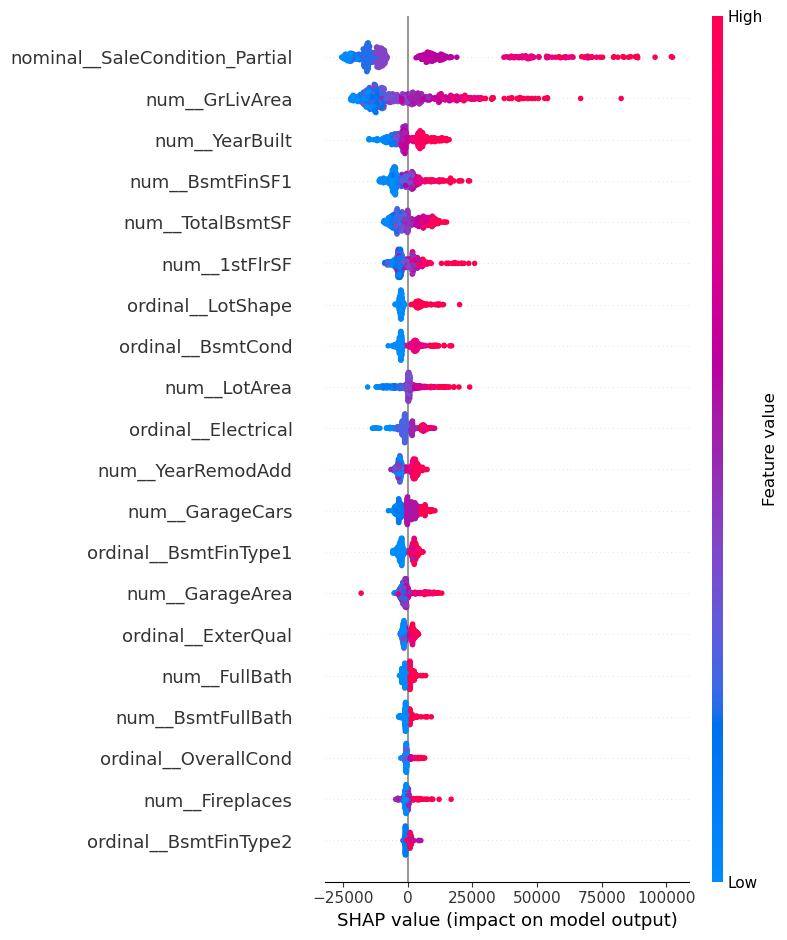

In [188]:
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names)

### Compare SHAP Values and feature_importances
**Note:** Because I am evaluating my SHAP values on a model trained on unseen data (X_test), I also need to consider feature_importances trained on this same data, not the full dataset (X, y) as was done above. This allows for a fair comparison between the two, but means the feature_importances here will differ from the feature importances in the above section, pulled from a model trained on the full dataset. *(i.e., cannot compare ranking in table below with feature_importances_df)*

In [222]:
# Compare SHAP importance with traditional feature importance
shap_importance = np.mean(np.abs(shap_values), axis=0)

# Get feature names from the preprocessor
feature_names = final_model.named_steps['preprocessor'].get_feature_names_out()

shap_ranking = pd.DataFrame({
    'Feature': feature_names,
    'SHAP_Importance': shap_importance
}).sort_values('SHAP_Importance', ascending=False)

# GradientBoosting feature importance - access from the regressor, not the pipeline
gb_importance = final_model.named_steps['regressor'].feature_importances_
gb_ranking = pd.DataFrame({
    'Feature': feature_names,
    'GB_Importance': gb_importance
}).sort_values('GB_Importance', ascending=False)

# Display with clear labels
print("=" * 70)
print("FEATURE IMPORTANCE COMPARISON")
print("=" * 70)
print(f"{'SHAP Importance':<32} {'GradientBoosting Importance':<35}")
print("-" * 70)

# Display comparison
for i in range(10):
    shap_feat = shap_ranking.iloc[i]['Feature'][:15]
    gb_feat = gb_ranking.iloc[i]['Feature'][:15]
    print(f"{i+1:2d}. {shap_feat:15s}\t\t{i+1:2d}. {gb_feat}")

FEATURE IMPORTANCE COMPARISON
SHAP Importance                  GradientBoosting Importance        
----------------------------------------------------------------------
 1. ordinal__Overal		 1. ordinal__Overal
 2. num__GrLivArea 		 2. num__GrLivArea
 3. num__YearBuilt 		 3. num__1stFlrSF
 4. num__BsmtFinSF1		 4. ordinal__ExterQ
 5. num__TotalBsmtS		 5. num__BsmtFinSF1
 6. num__1stFlrSF  		 6. num__TotalBsmtS
 7. ordinal__ExterQ		 7. num__GarageCars
 8. ordinal__Kitche		 8. num__GarageArea
 9. num__LotArea   		 9. ordinal__Kitche
10. ordinal__Overal		10. num__FullBath


In [226]:
# feature importances for model trained on all the data, X,y
feature_importances_df.sort_values(by=['Importance'], ascending=False)[:10]

,Importance
ordinal__OverallQual,0.495782
num__GrLivArea,0.142159
num__1stFlrSF,0.043248
num__TotalBsmtSF,0.042166
num__GarageArea,0.025778
num__BsmtFinSF1,0.025441
num__YearBuilt,0.025400
ordinal__ExterQual,0.022155
num__GarageCars,0.017665
ordinal__KitchenQual,0.017258


# Summary

[Contents](#Contents)

### Model scores and train-test gaps:

In [143]:
tuning_results_df.sort_values(by=['mean-cv on X and y'], ascending=False)

,mean-cv on X and y,train score,test score,train-test gap
Model _6,0.9198,0.9914,0.9319,0.0596
Model _1,0.9166,0.9984,0.9208,0.0776
Model _2,0.9136,0.9946,0.9241,0.0705
Model _3,0.9130,0.9844,0.9325,0.0519
Model _5,0.9103,0.9737,0.9299,0.0438
Model _0,0.9082,0.9667,0.9281,0.0386
Model _4,0.9082,0.9768,0.9256,0.0512


### Best model hyperparameters:

In [145]:
random_search_6.best_params_

{'regressor__learning_rate': 0.09822981328599736,
 'regressor__max_depth': 4,
 'regressor__n_estimators': 271}

### Top 10 feature importances:
on full dataset

In [149]:
feature_importances_df.sort_values(by=['Importance'], ascending=False)[:10]

,Importance
ordinal__OverallQual,0.495782
num__GrLivArea,0.142159
num__1stFlrSF,0.043248
num__TotalBsmtSF,0.042166
num__GarageArea,0.025778
num__BsmtFinSF1,0.025441
num__YearBuilt,0.025400
ordinal__ExterQual,0.022155
num__GarageCars,0.017665
ordinal__KitchenQual,0.017258


### SHAP Analysis:
on train-test split data

In [232]:
# Display with clear labels
print("=" * 70)
print("FEATURE IMPORTANCE COMPARISON")
print("=" * 70)
print(f"{'SHAP Importance':<32} {'GradientBoosting Importance':<35}")
print("-" * 70)

# Display comparison
for i in range(10):
    shap_feat = shap_ranking.iloc[i]['Feature'][:15]
    gb_feat = gb_ranking.iloc[i]['Feature'][:15]
    print(f"{i+1:2d}. {shap_feat:15s}\t\t{i+1:2d}. {gb_feat}")

FEATURE IMPORTANCE COMPARISON
SHAP Importance                  GradientBoosting Importance        
----------------------------------------------------------------------
 1. ordinal__Overal		 1. ordinal__Overal
 2. num__GrLivArea 		 2. num__GrLivArea
 3. num__YearBuilt 		 3. num__1stFlrSF
 4. num__BsmtFinSF1		 4. ordinal__ExterQ
 5. num__TotalBsmtS		 5. num__BsmtFinSF1
 6. num__1stFlrSF  		 6. num__TotalBsmtS
 7. ordinal__ExterQ		 7. num__GarageCars
 8. ordinal__Kitche		 8. num__GarageArea
 9. num__LotArea   		 9. ordinal__Kitche
10. ordinal__Overal		10. num__FullBath


In [234]:
# save data for model comparisons
gb_models = tuning_results_df.copy()
gb_models['algorithm'] = 'GradientBoosting'

In [236]:
gb_models

,mean-cv on X and y,train score,test score,train-test gap,algorithm
Model _0,0.9082,0.9667,0.9281,0.0386,GradientBoosting
Model _1,0.9166,0.9984,0.9208,0.0776,GradientBoosting
Model _2,0.9136,0.9946,0.9241,0.0705,GradientBoosting
Model _3,0.9130,0.9844,0.9325,0.0519,GradientBoosting
Model _4,0.9082,0.9768,0.9256,0.0512,GradientBoosting
Model _5,0.9103,0.9737,0.9299,0.0438,GradientBoosting
Model _6,0.9198,0.9914,0.9319,0.0596,GradientBoosting


In [240]:
gb_models.index.name = 'model'
gb_models = gb_models.reset_index()

In [242]:
gb_models

,model,mean-cv on X and y,train score,test score,train-test gap,algorithm
0,Model _0,0.9082,0.9667,0.9281,0.0386,GradientBoosting
1,Model _1,0.9166,0.9984,0.9208,0.0776,GradientBoosting
2,Model _2,0.9136,0.9946,0.9241,0.0705,GradientBoosting
3,Model _3,0.9130,0.9844,0.9325,0.0519,GradientBoosting
4,Model _4,0.9082,0.9768,0.9256,0.0512,GradientBoosting
5,Model _5,0.9103,0.9737,0.9299,0.0438,GradientBoosting
6,Model _6,0.9198,0.9914,0.9319,0.0596,GradientBoosting


In [244]:
gb_models.to_csv('gradient_boosting_models.csv')

# Resources

[Contents](#Contents)

[Comparing Model Performance: Decision Tree Baseline to Gradient Boosting Ensembles
](https://machinelearningmastery.com/boosting-over-bagging-enhancing-predictive-accuracy-with-gradient-boosting-regressors/)

# example cv-fold analysis:

In [246]:
cv_scores = cross_val_score(gb_best_model_6, X, y)

In [247]:
cv_scores

array([0.85237731, 0.92529127, 0.93901871, 0.93892317, 0.94324767])

1. BASIC STATISTICS:
Mean CV Score: 0.919772
Standard Deviation: 0.038278
Standard Error: 0.017118
Coefficient of Variation: 4.16%

2. CONFIDENCE INTERVALS:
95% Confidence Interval: [0.872243, 0.967300]
Bootstrap 95% CI: [0.869686, 0.938942]

3. DISTRIBUTION ANALYSIS:
Minimum Score (Worst-case): 0.852377
Maximum Score (Best-case): 0.943248
Range: 0.090870
Median: 0.938923
Skewness: -1.3897 (left-skewed)
Kurtosis: 0.0868 (heavy-tailed)

4. RISK ASSESSMENT:
Performance below threshold (0.9): 1/5 folds
Probability of score < 0.9: 20.0%
5% VaR (worst 5% performance): 0.866960
20th percentile performance: 0.910708

5. OUTLIER DETECTION:
IQR Outlier Thresholds: [0.904700, 0.959610]
Low outliers: [0.85237731]
High outliers: []
Z-score outliers (|z| > 2): []

6. STABILITY METRICS:
Relative Standard Deviation: 0.0416
Stability Index (1 - RSD): 0.9584
Scores within 1 std of mean: 4/5 (80.0%)

7. PERFORMANCE RELIABILITY:
P(Score ≥ 0.85): 100.0%
P(Score ≥ 0.9): 80.0%
P(Score ≥ 0.92): 80.0%
P(Score

/var/folders/tn/yy89yz_94q5b571nxcz7c_2m0000gn/T/ipykernel_90076/1441983616.py:145: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(cv_scores, labels=['Model'])


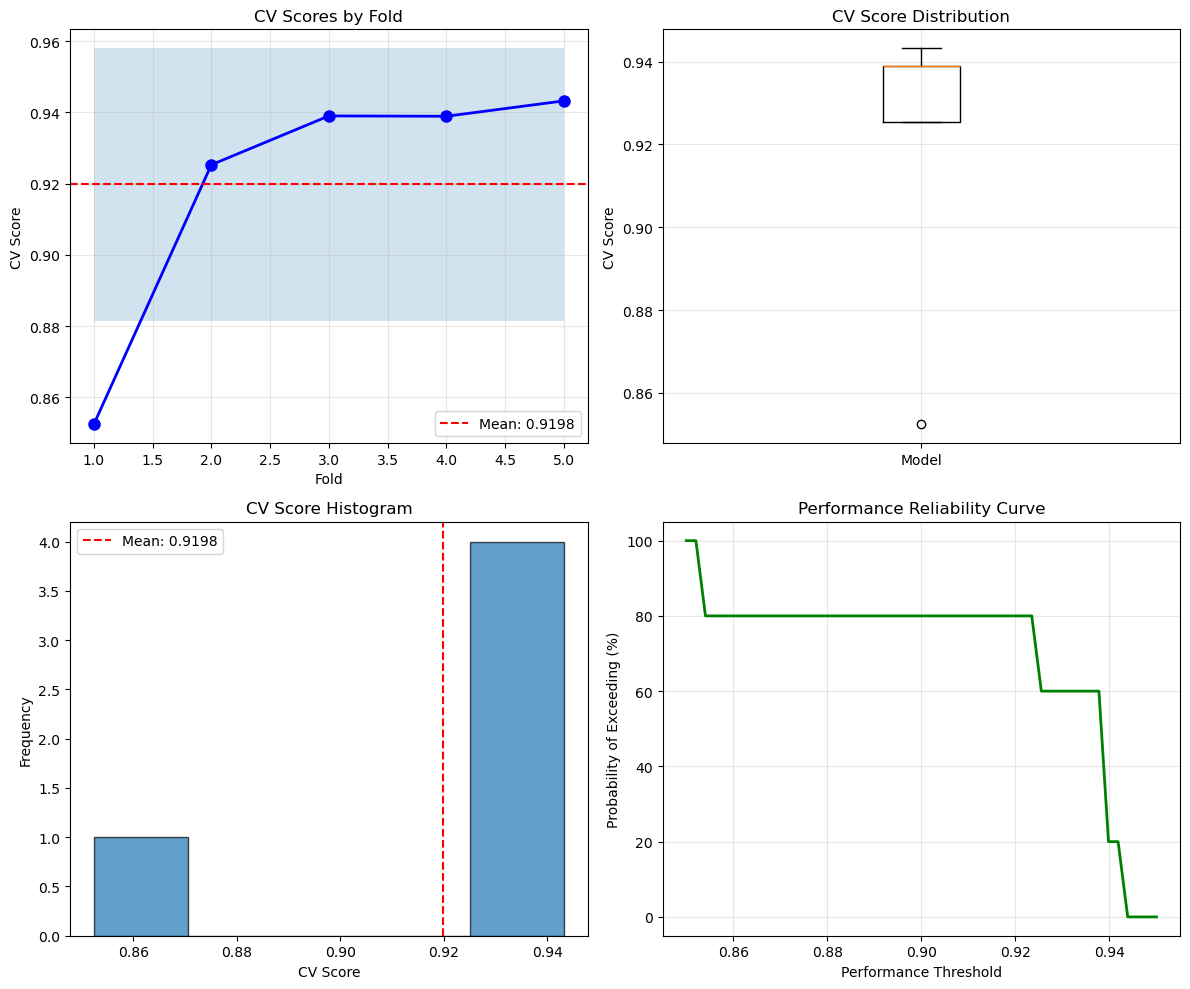

In [253]:
import numpy as np
import scipy.stats as stats
from scipy.stats import bootstrap
import matplotlib.pyplot as plt

# 1. Basic Statistics
print("1. BASIC STATISTICS:")
print(f"Mean CV Score: {np.mean(cv_scores):.6f}")
print(f"Standard Deviation: {np.std(cv_scores, ddof=1):.6f}")
print(f"Standard Error: {stats.sem(cv_scores):.6f}")
print(f"Coefficient of Variation: {(np.std(cv_scores, ddof=1)/np.mean(cv_scores)*100):.2f}%")
print()

# 2. Confidence Intervals
print("2. CONFIDENCE INTERVALS:")
# 95% CI using t-distribution (appropriate for small sample)
confidence_level = 0.95
alpha = 1 - confidence_level
df = len(cv_scores) - 1
t_critical = stats.t.ppf(1 - alpha/2, df)
margin_error = t_critical * stats.sem(cv_scores)

ci_lower = np.mean(cv_scores) - margin_error
ci_upper = np.mean(cv_scores) + margin_error
print(f"95% Confidence Interval: [{ci_lower:.6f}, {ci_upper:.6f}]")

# Bootstrap CI for comparison
def bootstrap_mean(data):
    return np.mean(data)

bootstrap_ci = bootstrap((cv_scores,), bootstrap_mean, n_resamples=10000, 
                        confidence_level=0.95, random_state=42)
print(f"Bootstrap 95% CI: [{bootstrap_ci.confidence_interval.low:.6f}, {bootstrap_ci.confidence_interval.high:.6f}]")
print()

# 3. Distribution Analysis
print("3. DISTRIBUTION ANALYSIS:")
print(f"Minimum Score (Worst-case): {np.min(cv_scores):.6f}")
print(f"Maximum Score (Best-case): {np.max(cv_scores):.6f}")
print(f"Range: {np.max(cv_scores) - np.min(cv_scores):.6f}")
print(f"Median: {np.median(cv_scores):.6f}")

# Skewness and Kurtosis
skewness = stats.skew(cv_scores)
kurtosis = stats.kurtosis(cv_scores)
print(f"Skewness: {skewness:.4f} ({'right-skewed' if skewness > 0 else 'left-skewed' if skewness < 0 else 'symmetric'})")
print(f"Kurtosis: {kurtosis:.4f} ({'heavy-tailed' if kurtosis > 0 else 'light-tailed' if kurtosis < 0 else 'normal-tailed'})")
print()

# 4. Risk Assessment
print("4. RISK ASSESSMENT:")
mean_score = np.mean(cv_scores)
threshold = 0.90  # Example acceptable threshold

print(f"Performance below threshold ({threshold}): {np.sum(cv_scores < threshold)}/5 folds")
print(f"Probability of score < {threshold}: {np.mean(cv_scores < threshold)*100:.1f}%")

# Value at Risk (VaR) - 5th percentile performance
var_5 = np.percentile(cv_scores, 5)
print(f"5% VaR (worst 5% performance): {var_5:.6f}")

# Expected performance in worst 20% of cases
worst_20_pct = np.percentile(cv_scores, 20)
print(f"20th percentile performance: {worst_20_pct:.6f}")
print()

# 5. Outlier Detection
print("5. OUTLIER DETECTION:")
# Using IQR method
Q1 = np.percentile(cv_scores, 25)
Q3 = np.percentile(cv_scores, 75)
IQR = Q3 - Q1
outlier_threshold_low = Q1 - 1.5 * IQR
outlier_threshold_high = Q3 + 1.5 * IQR

outliers_low = cv_scores[cv_scores < outlier_threshold_low]
outliers_high = cv_scores[cv_scores > outlier_threshold_high]

print(f"IQR Outlier Thresholds: [{outlier_threshold_low:.6f}, {outlier_threshold_high:.6f}]")
print(f"Low outliers: {outliers_low}")
print(f"High outliers: {outliers_high}")

# Z-score method
z_scores = np.abs(stats.zscore(cv_scores))
z_outliers = cv_scores[z_scores > 2]  # Common threshold
print(f"Z-score outliers (|z| > 2): {z_outliers}")
print()

# 6. Stability Metrics
print("6. STABILITY METRICS:")
# Relative standard deviation
rel_std = np.std(cv_scores, ddof=1) / np.mean(cv_scores)
print(f"Relative Standard Deviation: {rel_std:.4f}")

# Stability index (1 - CV)
stability_index = 1 - rel_std
print(f"Stability Index (1 - RSD): {stability_index:.4f}")

# Performance consistency (% of scores within 1 std of mean)
within_1_std = np.sum(np.abs(cv_scores - mean_score) <= np.std(cv_scores, ddof=1))
print(f"Scores within 1 std of mean: {within_1_std}/5 ({within_1_std/5*100:.1f}%)")
print()

# 7. Performance Reliability
print("7. PERFORMANCE RELIABILITY:")
# Probability of achieving certain performance levels
thresholds = [0.85, 0.90, 0.92, 0.95]
for thresh in thresholds:
    prob = np.mean(cv_scores >= thresh) * 100
    print(f"P(Score ≥ {thresh}): {prob:.1f}%")
print()

# 8. Individual Fold Analysis
print("8. INDIVIDUAL FOLD ANALYSIS:")
for i, score in enumerate(cv_scores, 1):
    deviation = score - mean_score
    z_score = (score - mean_score) / np.std(cv_scores, ddof=1)
    print(f"Fold {i}: {score:.6f} (deviation: {deviation:+.6f}, z-score: {z_score:+.2f})")

# Identify best and worst performing folds
best_fold = np.argmax(cv_scores) + 1
worst_fold = np.argmin(cv_scores) + 1
print(f"\nBest performing fold: Fold {best_fold} ({np.max(cv_scores):.6f})")
print(f"Worst performing fold: Fold {worst_fold} ({np.min(cv_scores):.6f})")
print(f"Performance gap: {np.max(cv_scores) - np.min(cv_scores):.6f}")

# 9. Visualization Code

import matplotlib.pyplot as plt

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# 1. Individual fold scores
ax1.plot(range(1, 6), cv_scores, 'bo-', linewidth=2, markersize=8)
ax1.axhline(y=np.mean(cv_scores), color='r', linestyle='--', label=f'Mean: {np.mean(cv_scores):.4f}')
ax1.fill_between(range(1, 6), np.mean(cv_scores) - np.std(cv_scores, ddof=1), 
                 np.mean(cv_scores) + np.std(cv_scores, ddof=1), alpha=0.2)
ax1.set_xlabel('Fold')
ax1.set_ylabel('CV Score')
ax1.set_title('CV Scores by Fold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Box plot
ax2.boxplot(cv_scores, labels=['Model'])
ax2.set_ylabel('CV Score')
ax2.set_title('CV Score Distribution')
ax2.grid(True, alpha=0.3)

# 3. Histogram
ax3.hist(cv_scores, bins=5, edgecolor='black', alpha=0.7)
ax3.axvline(np.mean(cv_scores), color='red', linestyle='--', label=f'Mean: {np.mean(cv_scores):.4f}')
ax3.set_xlabel('CV Score')
ax3.set_ylabel('Frequency')
ax3.set_title('CV Score Histogram')
ax3.legend()

# 4. Performance reliability
thresholds = np.linspace(0.85, 0.95, 50)
probabilities = [np.mean(cv_scores >= t) * 100 for t in thresholds]
ax4.plot(thresholds, probabilities, 'g-', linewidth=2)
ax4.set_xlabel('Performance Threshold')
ax4.set_ylabel('Probability of Exceeding (%)')
ax4.set_title('Performance Reliability Curve')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# Extra

In [ ]:
# # redo visualization for train-test learning rates, with optimized model
# def evaluate_max_depths(depth_range):
#     results = []
    
#     for max_depth_value in depth_range:
#         for name, pipeline in pipelines.items():
#             # Create a copy to avoid modifying the original
#             temp_pipeline = Pipeline(pipeline.steps)
#             temp_pipeline.named_steps['regressor'].set_params(
#                 subsample=0.8,
#                 max_depth=max_depth_value,
#                 n_estimators=388, 
#                 learning_rate=0.060453878822552744, 
#                 random_state=42
#             )
            
#             temp_pipeline.fit(X_train, y_train)
#             train_score = temp_pipeline.score(X_train, y_train)
#             test_score = temp_pipeline.score(X_test, y_test)
#             results.append({
#                 'model': name,
#                 'max_depth': max_depth_value,
#                 'training_score': train_score,
#                 'testing_score': test_score
#             })
    
#     return pd.DataFrame(results)

# rscv_max_depth_df = evaluate_max_depths(range(1, 10))
# rscv_max_depth_df

# print(f'gap between train-test at depth=3: {0.981577 - 0.938660}%')
# print(f'gap between train-test at depth=4: {0.991145 - 0.935696}%')

# plt.figure(figsize=(10,6))

# for model_name in rscv_max_depth_df['model'].unique():
#     model_data = rscv_max_depth_df[rscv_max_depth_df['model'] == model_name]
    
#     plt.plot(model_data['max_depth'], model_data['training_score'], 'o-', label='Training')
#     plt.plot(model_data['max_depth'], model_data['testing_score'], 's-', label='Testing')
    
# plt.title(f'Training vs. Testing Scores by Maximum Depth')
# plt.xticks(range(0, 21, 2))
# plt.xlabel('Max. Depth')
# plt.ylabel('R² Score')
# plt.legend()
# plt.grid(True, alpha=0.3)

# print(f'RSCV optimized parameters: n_estimators=388, learning_rate=0.0605')
# plt.show()

### Visualize learning curves:

for a single parameter, max_depth, how do the test and train scores vary? 
(This may change if another parameter is added...)

In [ ]:
# def evaluate_max_depths(depth_range):
#     results = []
    
#     for max_depth_value in depth_range:
#         for name, pipeline in pipelines.items():
#             # Create a copy to avoid modifying the original
#             temp_pipeline = Pipeline(pipeline.steps)
#             temp_pipeline.named_steps['regressor'].set_params(
#                 max_depth=max_depth_value, 
#                 random_state=42
#             )
            
#             temp_pipeline.fit(X_train, y_train)
#             train_score = temp_pipeline.score(X_train, y_train)
#             test_score = temp_pipeline.score(X_test, y_test)
#             results.append({
#                 'model': name,
#                 'max_depth': max_depth_value,
#                 'training_score': train_score,
#                 'testing_score': test_score
#             })
    
#     return pd.DataFrame(results)

# max_depth_df = evaluate_max_depths(range(1, 20))
# max_depth_df

# print(f'untuned model:')
# print(f'gap between train-test at depth=3: {0.966719-0.928099}%')
# print(f'gap between train-test at depth=4: {0.979942-0.933690}%')

# plt.figure(figsize=(10,6))

# for model_name in max_depth_df['model'].unique():
#     model_data = max_depth_df[max_depth_df['model'] == model_name]
    
#     plt.plot(model_data['max_depth'], model_data['training_score'], 'o-', label='Training')
#     plt.plot(model_data['max_depth'], model_data['testing_score'], 's-', label='Testing')
    
# plt.title(f'Training vs. Testing Scores by Maximum Depth')
# plt.xticks(range(0, 21, 2))
# plt.xlabel('Max. Depth')
# plt.ylabel('R² Score')
# plt.legend()
# plt.grid(True, alpha=0.3)

# plt.show()

# RFECV

In [ ]:
# from sklearn.feature_selection import RFECV

# numerical_transformer = Pipeline(steps=[
#     ('num', 'passthrough')
# ])

# nominal_transformer = Pipeline(steps=[
#     ('nominal', OneHotEncoder(handle_unknown='ignore'))
# ])

# ord_categories = [ordinal_order[feature] for feature in ordinal_features_list]
# ordinal_transformer = Pipeline(steps=[
#     ('ordinal', OrdinalEncoder(categories=ord_categories))
# ])

# # Set up preprocessor
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numerical_transformer, numerical_features_list),
#         ('nominal', nominal_transformer, nominal_features_list),
#         ('ordinal', ordinal_transformer, ordinal_features_list)
# ])

# # Create the base model for RFECV
# rfe_model = ensemble.GradientBoostingRegressor(random_state=42)

# # Create RFECV selector
# rfe_selector = RFECV(
#     estimator=rfe_model, 
#     step=1, 
#     cv=5,
#     scoring='r2', 
#     min_features_to_select=1
# )

# # Updated pipeline with RFECV
# pipelines = {
#     'gb_rfe': Pipeline(steps=[
#         ('preprocessor', preprocessor),
#         ('feature_selection', rfe_selector),
#         ('regressor', ensemble.GradientBoostingRegressor(random_state=42))
#     ])
# }

# # Fit the pipeline
# pipelines['gb_rfe'].fit(X, y)

# # Make predictions
# predictions = pipelines['gb_rfe'].predict(X_test)

# # Access the selected features
# selected_mask = pipelines['gb_rfe'].named_steps['feature_selection'].support_
# feature_names = pipelines['gb_rfe'].named_steps['preprocessor'].get_feature_names_out()
# selected_features = feature_names[selected_mask]
# print(f"Selected features: {selected_features}")

# len(selected_features)

### train-test with optimized model

In [ ]:
# # redo visualization for train-test learning rates, with optimized model
# def evaluate_max_depths(depth_range):
#     results = []
    
#     for max_depth_value in depth_range:
#         for name, pipeline in pipelines.items():
#             # Create a copy to avoid modifying the original
#             temp_pipeline = Pipeline(pipeline.steps)
#             temp_pipeline.named_steps['regressor'].set_params(
#                 max_depth=max_depth_value,
#                 n_estimators=388, 
#                 learning_rate=0.060453878822552744, 
#                 random_state=42
#             )
            
#             temp_pipeline.fit(X_train, y_train)
#             train_score = temp_pipeline.score(X_train, y_train)
#             test_score = temp_pipeline.score(X_test, y_test)
#             results.append({
#                 'model': name,
#                 'max_depth': max_depth_value,
#                 'training_score': train_score,
#                 'testing_score': test_score
#             })
    
#     return pd.DataFrame(results)

# rscv_max_depth_df = evaluate_max_depths(range(1, 20))
# rscv_max_depth_df

# print(f'tuned model:')
# print(f'gap between train-test at depth=3: {0.981101 - 0.942133}%')
# print(f'gap between train-test at depth=4: {0.990049 - 0.933238}%')

### Train test performance for RSCV optimized model

In [ ]:
# plt.figure(figsize=(10,6))

# for model_name in rscv_max_depth_df['model'].unique():
#     model_data = rscv_max_depth_df[rscv_max_depth_df['model'] == model_name]
    
#     plt.plot(model_data['max_depth'], model_data['training_score'], 'o-', label='Training')
#     plt.plot(model_data['max_depth'], model_data['testing_score'], 's-', label='Testing')
    
# plt.title(f'Training vs. Testing Scores by Maximum Depth')
# plt.xticks(range(0, 21, 2))
# plt.xlabel('Max. Depth')
# plt.ylabel('R² Score')
# plt.legend()
# plt.grid(True, alpha=0.3)

# print(f'RSCV optimized parameters: n_estimators=388, learning_rate=0.0605')
# plt.show()

**Note:** This is the model performance on train and test data, not the cv-score for the full dataset. This is why the optimal depth for train-test is 3, while the optimal depth for the best cv-score on the full data set is 4. 